In [ ]:
# Broadcasted shape
def broadcasted_shape(shape_X, shape_Y):

    max_len = max(len(shape_X), len(shape_Y))
    min_len = min(len(shape_X), len(shape_Y))
    swapped = False

    if len(shape_X) < max_len:
        swapped = True
        L, S = shape_Y, shape_X # L = long, S = short
    else:
        L, S = shape_X, shape_Y

    L_rev = L[::-1]
    S_rev = S[::-1]

    result_shape = []
    axes_L_expanded = []
    axes_S_expanded = []

    for i in range(min_len):
        dim_L = L_rev[i]
        dim_S = S_rev[i]
        if dim_L == 1 and dim_S != 1:
            axes_L_expanded.append(max_len  -1- i)
        elif dim_L != 1 and dim_S == 1:
            axes_S_expanded.append(max_len  -1- i)
        if dim_L == 1 or dim_S == 1 or dim_L == dim_S:
            result_shape.append(max(dim_L,dim_S))
        else:
            raise ValueError(f"Shapes {shape_X} and {shape_Y} not broadcastable")


    result_shape += L_rev[(min_len):]

    result_shape = tuple(result_shape[::-1])
    axes_L_expanded = tuple(axes_L_expanded[::-1])
    axes_S_expanded = tuple(axes_S_expanded[::-1])

    if swapped:
        return result_shape, axes_S_expanded, max_len - min_len,  axes_L_expanded, 0
    else:
        return result_shape,  axes_L_expanded, 0, axes_S_expanded, max_len - min_len

def unbroadcast(arr, ax, pad):
    return np.sum(np.sum(arr, axis = ax, keepdims = True), axis = tuple(range(pad)))
class ag: # AutoGrad

    #################
    # ENTRYWISE OPS #
    #################
    def log(input):
        output = ag.Tensor(np.log(input.value), inputs=[input], op="log")
        def _backward():
            input.grad += output.grad / input.value
            return None
        output._backward = _backward
        return output

    def exp(input):

        output = ag.Tensor(np.exp(input.value), inputs=[input], op="exp")

        def _backward():
            input.grad += output.grad * output.value
            return None

        output._backward = _backward
        return output

    def relu(input):
        output = ag.Tensor(np.maximum(0, input.value), inputs=[input], op="relu")

        def _backward():
            input.grad += (input.value > 0)*output.grad
            return None

        output._backward = _backward
        return output



    #################
    # REDUCTIVE OPS #
    #################
    def sum(input,axis = None, keepdims = False):
        output = ag.Tensor(np.sum(input.value, axis = axis, keepdims = keepdims), inputs = [input], op='sum')
        def _backward():
            if axis == None or keepdims:
                input.grad += output.grad
            else:
                input.grad += np.expand_dims(output.grad, axis = axis)
            return None
        output._backward = _backward
        return output

    def matmul(input1, input2):
        return input1@input2
    ###############
    # SHAPING OPS #
    ###############

    def expand_dims(input, axis):
        output = ag.Tensor(np.expand_dims(input.value,axis=axis), inputs = [input])
        def _backward():
            input.grad += np.squeeze(output.grad, axis = axis)
            return None
        output._backward = _backward
        return output

    def reshape(input, newshape):
        output = ag.Tensor(np.reshape(input.value, newshape), inputs=[input], op="reshape")
        def _backward():
            input.grad += np.reshape(output.grad, input.shape)
            return None
        output._backward = _backward
        return output

    def moveaxis(input, source, destination):
        output = ag.Tensor(np.moveaxis(input.value, source, destination), inputs=[input], op="moveaxis")

        def _backward():
            input.grad += np.moveaxis(output.grad, source, destination)
            return None
        output._backward = _backward
        return output


    class Tensor: # Tensor with grads
        def __init__(self,
                     value,
                     op="",
                     _backward= lambda : None,
                     inputs=[],
                     label="",
                     requires_grad=True):

            if type(value) in [float ,int]:
                value = np.array(value).astype(np.float64)
            self.value = value.astype(np.float64)
            self.grad = np.zeros_like(self.value).astype(np.float64)

            self.shape = value.shape

            self._backward = _backward
            self.inputs = inputs

            self.op = op
            self.label = label

            self.requires_grad = requires_grad

        def topological_sort(self):
            topo_order = []
            visited = set()

            def dfs(node):
                if node not in visited:
                    visited.add(node)
                    for input in node.inputs:
                        dfs(input)
                    topo_order.append(node)

            dfs(self)
            return topo_order

        def backward(self):
            self.grad = np.array(1.0).astype(np.float64)

            topo_order = self.topological_sort()

            for node in reversed(topo_order):
                node._backward()



        def __add__(self, other):

            if type(other) in [float, int]:
                other = ag.Tensor(1.0*other)
            result_shape, ax1, pad1, ax2, pad2 = broadcasted_shape(self.shape, other.shape)

            output = ag.Tensor(self.value + other.value,
                               inputs=[self, other], op="add")
            def _backward():
                self.grad += unbroadcast(output.grad, ax1, pad1)
                other.grad += unbroadcast(output.grad, ax2, pad2)

            output._backward = _backward
            return output

        def __sub__(self,other):
            return self + other*(-1)

        def __neg__(self):
            output = ag.Tensor(-self.value, inputs=[self], op="neg")
            def _backward():
                self.grad -= output.grad
                return None
            output._backward = _backward
            return output

        def __mul__(self, other):
            if type(other) in [float, int]:
                other = ag.Tensor(1.0*other)
            result_shape, ax1, pad1, ax2, pad2 = broadcasted_shape(self.shape, other.shape)

            output = ag.Tensor(self.value * other.value,
                               inputs=[self, other], op="mul")
            def _backward():
                self.grad += unbroadcast(output.grad*other.value, ax1, pad1)
                other.grad += unbroadcast(output.grad*self.value, ax2, pad2)

            output._backward = _backward
            return output

        def __truediv__(self,other):
            return self*(other**(-1))


        def __pow__(self, exponent): # exponent is just a python float
            output = ag.Tensor(self.value ** exponent,
                               inputs=[self],
                               op=f"pow({exponent})")

            def _backward():

                self.grad += (exponent * self.value**(exponent-1)) * output.grad
                return None

            output._backward = _backward
            return output


        def __getitem__(self, idx):
            output = ag.Tensor(np.array(self.value[idx]),
                               inputs = [self],
                               op=f"[...]")
            def _backward():
                self.grad[idx] += output.grad # idx must not have repeats!
                return None
            output._backward = _backward
            return output

        def __radd__(self, other):
            return self + other

        def __rmul__(self, other):
            return self * other

        def __rsub__(self, other):
            return (-self) + other

        def __rtruediv__(self, other):
            return ag.Tensor(other) / self


        def __matmul__(self,other):
            output = ag.Tensor(np.matmul(self.value,other.value),
                               inputs = [self,other],
                               op="matmul")

            # self.shape = (a,b,c, m,n)
            # other.shape = (a,b,c, n,p)
            # output.grad.shape == output.value.shape = (a,b,c, m,p)


            def _backward():
                if len(other.value.shape) == 1:
                    if len(self.value.shape) == 1:
                        raise Exception("To take the dot-product of two vectors, use ag.sum(x*y) instead.")
                    else:
                        self.grad += np.matmul(output.grad[:,None], other.value[None,:])
                else:
                    self.grad += np.matmul(output.grad, np.moveaxis(other.value,-1,-2))
                axis = list(range(len(self.value.shape)-1))
                other.grad += np.tensordot(self.value, output.grad, axes = [axis,axis])
                return None
            output._backward = _backward
            return output

        def reshape(self, *newshape):
            output = ag.Tensor(np.reshape(self.value, tuple(newshape)), inputs=[self], op="reshape")
            def _backward():
                self.grad += np.reshape(output.grad, self.shape)
                return None
            output._backward = _backward
            return output



        def __repr__(self) -> str:
            return "Value:\n"+self.value.__repr__() + "\nGrad:\n" + self.grad.__repr__()
        # def __repr__(self) -> str:
        #     return "Value:\n"+self.value.__repr__() + "\nGrad:\n" + self.grad.__repr__()

In [ ]:
class nn:
    # A fake python class so that we can use nn as an "namespace"
    # This way we can avoid having an actual python module
    # which would create more files for you to have to download
    # and for me to upload.

    # But the sacrifice is that the class inheritance is a bit wonky
    # Maybe someone more well-versed in python class inheritance can help me out
    # Email me if you'd like to contribute to making this class better next time

    class Module:
        def __init__(self):
            self._parameters = {}
            self._modules = {}

        def forward(self, *inputs):
            raise NotImplementedError

        def __call__(self, *inputs):
            return self.forward(*inputs)

        def parameters(self):
            params = list(self._parameters.values())
            for module in self._modules.values():
                params.extend(module.parameters())
            return params

        def __setattr__(self, name, value):
            object.__setattr__(self, name, value)
            if isinstance(value, nn.Module):
                self._modules[name] = value
            elif isinstance(value, ag.Tensor):
                self._parameters[name] = value


    class Linear(Module):
        def __init__(self, in_features, out_features):
            nn.Module.__init__(self)
            kaiming_he_init_constant = np.sqrt(2 / in_features)

            self.weight = ag.Tensor(np.random.randn(in_features, out_features) * kaiming_he_init_constant )
            self.bias = ag.Tensor(np.zeros(out_features))

            # these do not trigger __setattr__
            self._parameters['weight'] = self.weight
            self._parameters['bias'] = self.bias

        def forward(self, x):
            return ag.matmul(x, self.weight) + self.bias


    class MSELoss:
        def __call__(self, input, target):
            N = target.value.shape[0]
            return ag.sum((target - input)**2) / N

    class BinaryCrossEntropyLoss:
        def __call__(self, input, target):
            N = target.value.shape[0]
            return ag.sum( ag.log(1.0+ ag.exp(-input*target))) / N

    class CrossEntropyLoss:
        def __call__(self, input, target):
            # input should be an ag.Tensor of shape (N, num_classes)
            # target should be a numpy array of shape (N,) of elements of [0,1,..., num_classes-1]

            z = input
            y = target

            expz = ag.exp(z)

            p = expz / ag.sum(expz, axis=-1, keepdims=True)
            N = z.shape[0]
            l = ag.sum(-ag.log(p[np.arange(N), y]))/N
            return l

In [ ]:
class optim:
    class SGD:
        def __init__(self, parameters, lr=0.01):
            self.parameters = parameters
            self.lr = lr

        def step(self):
            for p in self.parameters:
                p.value -= self.lr * p.grad

        def zero_grad(self):
            for p in self.parameters:
                p.grad = np.zeros_like(p.value)

    class SGDWithMomentum:
        def __init__(self, parameters, lr=0.01, momentum=0.9):
            # momentum is gamma
            self.parameters = parameters
            self.lr = lr
            self.momentum = momentum
            self.velocities = [np.zeros_like(p.value) for p in parameters]

        def step(self):
            for i, p in enumerate(self.parameters):
                self.velocities[i] = self.momentum * self.velocities[i] + p.grad
                p.value -= self.lr * self.velocities[i]

        def zero_grad(self):
            for p in self.parameters:
                p.grad = np.zeros_like(p.value)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
x = np.random.randn(10, 3)
w_true = np.random.randn(3)
b = np.random.randn(1)
eps = 0.1 * np.random.randn(10)
y = x @ w_true + b + eps


X = np.hstack([x, np.ones((x.shape[0], 1))])

# Least squares solution
w_b_hat = np.linalg.inv(X.T @ X) @ X.T @ y

w_hat = w_b_hat[:-1]
b_hat = w_b_hat[-1]

print("True weights:", w_true)
print("True bias:", b)
print("Estimated weights (Least Squares):", w_hat)
print("Estimated bias (Least Squares):", b_hat)


True weights: [-0.60170661  1.85227818 -0.01349722]
True bias: [-1.05771093]
Estimated weights (Least Squares): [-0.66197053  1.91497468  0.03291901]
Estimated bias (Least Squares): -1.024653850130243


In [ ]:

class LinearModel(nn.Module):
    def __init__(self, input_dim):
        nn.Module.__init__(self)
        self.linear = nn.Linear(input_dim, 1)  # One output for regression

    def forward(self, x):
        return self.linear(x)


In [ ]:

import time

X = ag.Tensor(x)
yten = ag.expand_dims(ag.Tensor(y),1)
model = LinearModel(3)

num_epochs = 100
start_time = time.time()
optimizer = optim.SGD(model.parameters(), lr=0.01)


criterion = nn.MSELoss()
losses_SGD = []
for epoch in range(num_epochs):



    optimizer.zero_grad()
    outputs = model(X)

    loss = criterion(outputs, yten)
    loss.backward()
    optimizer.step()
    losses_SGD.append(loss.value)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.value:.10f}')
end_time = time.time()
total_time = end_time - start_time

print(f"Total training time: {total_time:.4f} seconds")
print("weight", model.linear.weight.value)
print("bias",model.linear.bias.value)

Epoch [100/100], Loss: 0.1399559162
Total training time: 0.1010 seconds
weight [[-0.63790891]
 [ 1.4141048 ]
 [-0.01425881]]
bias [-1.26017227]


In [ ]:

import time

X = ag.Tensor(x)
yten = ag.expand_dims(ag.Tensor(y),1)
model = LinearModel(3)

num_epochs = 100
start_time = time.time()

optimizer = optim.SGDWithMomentum(model.parameters(), lr=0.01)

criterion = nn.MSELoss()
losses_SGDwM = []
for epoch in range(num_epochs):



    optimizer.zero_grad()
    outputs = model(X)

    loss = criterion(outputs, yten)
    loss.backward()
    optimizer.step()
    losses_SGDwM.append(loss.value)

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.value:.10f}')
end_time = time.time()
total_time = end_time - start_time

print(f"Total training time: {total_time:.4f} seconds")
print("weight", model.linear.weight.value)
print("bias",model.linear.bias.value)

Epoch [100/100], Loss: 0.0033973801
Total training time: 0.0829 seconds
weight [[-0.66524381]
 [ 1.92072645]
 [ 0.03145352]]
bias [-1.01860544]


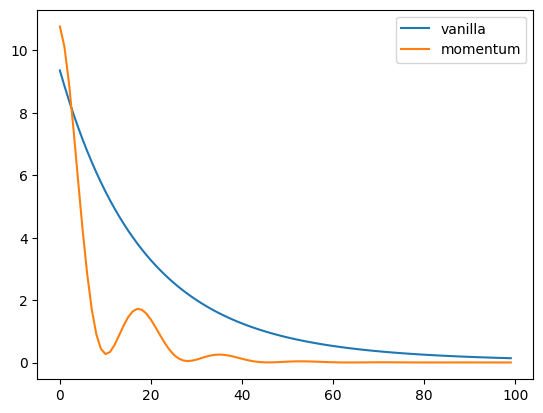

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses_SGD, label='vanilla')
plt.plot(losses_SGDwM, label='momentum')
plt.legend()